In [ ]:
# -*- coding: utf-8 -*-
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import model_from_json
 
import pandas as pd
import numpy as np
 
from sklearn.preprocessing import MinMaxScaler
#!pip install stats-to-pandas
# from pandas.stats import moments
 
import matplotlib.pyplot as plt
 
import os
import sys

import math
import pandas_datareader as web
 
import datetime
#os.chdir('/Users/farismismar/Dropbox/Stock Trading Using ML')
 
# Check if tensorflow is used
if (keras.backend.backend() != 'tensorflow' and keras.backend.image_data_format() != 'channels_last' and keras.backend.image_dim_ordering() != 'tf'):
    print('Install tensorflow, configure keras.json to include channels_last for image format and tf for image dimension ordering.')
    print('Program will now exit.')
    sys.exit(1)

In [ ]:
!python --version


Python 3.7.10


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AAPL_2005_2021_7_7.csv to AAPL_2005_2021_7_7.csv


In [ ]:
# # The tech stocks we'll use for this analysis
# companies_stock_trigger = ['AAPL', 'GOOG', 'TSLA']
 
# # Set up End and Start times for data grab
# end = datetime.datetime.now()
# start = datetime.date(2008,1,1)
 
# # if u want to use start with month and day with one year back سنه قبل يعنى ومعاها يوم وسهر 
# #start = datetime(end.year - 1, end.month, end.day)
 
 
# #For loop for grabing yahoo finance data and setting as a dataframe
# for stock in companies_stock_trigger:   
#     # Set DataFrame as the Stock Ticker
#     globals()[stock] = web.DataReader(stock, 'yahoo', start, end)

In [ ]:
# # # The tech stocks we'll use for this analysis
# companies_stock_trigger = ['AAPL', 'GOOG', 'TSLA']
 
# # Set up End and Start times for data grab
# end = datetime.datetime.now()
# start = datetime.date(2008,1,1)
 
# # if u want to use start with month and day with one year back سنه قبل يعنى ومعاها يوم وسهر 
# #start = datetime(end.year - 1, end.month, end.day)
 
 
# #For loop for grabing yahoo finance data and setting as a dataframe
# for stock in companies_stock_trigger:   
#     # Set DataFrame as the Stock Ticker
#   globals()[stock] = web.DataReader(stock, 'yahoo', start, end)

In [ ]:
#dataset.shape

In [ ]:
# Set the random seed
seed = 123
np.random.seed(seed)
 
# Import the datafile to memory first
TICKER = 'AAPL.NS'
 
dataset = pd.read_csv('AAPL_2005_2021_7_7.csv') 
#dataset = pd.read_csv('./Dataset/{}.csv'.format(TICKER))
 
# Sanity check. Missing values?
print('Number of missing values: {}'.format(dataset.isnull().sum().sum()))
dataset.head(5)

Number of missing values: 0


,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,1.156786,1.162679,1.117857,1.130179,0.971844,691992000
1,2005-01-04,1.139107,1.169107,1.124464,1.141786,0.981825,1096810400
2,2005-01-05,1.151071,1.165179,1.143750,1.151786,0.990424,680433600
3,2005-01-06,1.154821,1.159107,1.130893,1.152679,0.991192,705555200
4,2005-01-07,1.160714,1.243393,1.156250,1.236607,1.063362,2227450400


In [ ]:
dataset.shape

(4155, 7)

In [ ]:
 
# INDICATOR 1:
# MACD
def macd(df, n_fast=26, n_slow=12):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df
 
dataset = macd(dataset)

In [ ]:
dataset.isnull().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MACD_26_12        11
MACDsign_26_12    19
MACDdiff_26_12    19
dtype: int64

In [ ]:
# INDICATOR 2:
# Bollinger Bands ( 30, 40, 50 Days)
def bollinger_bands(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    print(df['Close'])
    MA = pd.Series(df['Close'].rolling(window=n, min_periods=n).mean())
    MSD = pd.Series(df['Close'].rolling(window=n, min_periods=n).std())
    b1 = 4 * MSD / MA
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    df = df.join(B1)
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    df = df.join(B2)
    return df
 
for i in np.array([30,40,50]):
    dataset = bollinger_bands(dataset, i)

0         1.130179
1         1.141786
2         1.151786
3         1.152679
4         1.236607
           ...    
4150    136.330002
4151    136.960007
4152    137.270004
4153    139.960007
4154    142.020004
Name: Close, Length: 4155, dtype: float64
0         1.130179
1         1.141786
2         1.151786
3         1.152679
4         1.236607
           ...    
4150    136.330002
4151    136.960007
4152    137.270004
4153    139.960007
4154    142.020004
Name: Close, Length: 4155, dtype: float64
0         1.130179
1         1.141786
2         1.151786
3         1.152679
4         1.236607
           ...    
4150    136.330002
4151    136.960007
4152    137.270004
4153    139.960007
4154    142.020004
Name: Close, Length: 4155, dtype: float64


In [ ]:
# INDICATOR 3:
# Stochastic Oscillator (d and k)
def stochastic_oscillator_d(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df
 
def stochastic_oscillator_k(df):
    """Calculate stochastic oscillator %K for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    df = df.join(SOk)
    return df
 
dataset = stochastic_oscillator_k(dataset)
 
for i in np.array([5, 9, 14]):
    dataset = stochastic_oscillator_d(dataset, i)

In [ ]:
# INDICATOR 4:
# Chande Momentum Oscillator
def chande_momentum_oscillator(df, n):
    """
    Chande Momentum Oscillator.
    Formula:
    cmo = 100 * ((sum_up - sum_down) / (sum_up + sum_down))
    """
 
    close_data = np.array(df['Close'])
 
    moving_period_diffs = [[(close_data[idx+1-n:idx+1][i] -
                 close_data[idx+1-n:idx+1][i-1]) for i in range(1, len(close_data[idx+1-n:idx+1]))] for idx in range(0, len(close_data))]
 
    sum_up = []
    sum_down = []
    for period_diffs in moving_period_diffs:
        ups = [val if val > 0 else 0 for val in period_diffs]
        sum_up.append(sum(ups))
        downs = [abs(val) if val < 0 else 0 for val in period_diffs]
        sum_down.append(sum(downs))
 
    sum_up = np.array(sum_up)
    sum_down = np.array(sum_down)
 
    cmo = pd.Series(100 * ((sum_up - sum_down) / (sum_up + sum_down)), name='Chande_'+str(n))
    df = df.join(cmo)
    return df

In [ ]:
# INDICATOR 5:
# Commodity Channel Index (30, 40, 50 Days)
def commodity_channel_index(df, n):
    """Calculate Commodity Channel Index for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((PP - PP.rolling(window=n, min_periods=n).mean()) / PP.rolling(window=n, min_periods=n).std(), name='CCI_' + str(n))
    df = df.join(CCI)
    return df
	
for i in np.array([30,40,50]):
    dataset = commodity_channel_index(dataset, i)

In [ ]:
# INDICATOR 6:
# Rate of Price Change (30, 40, 50 Days)
def rate_of_price_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(n - 1)
    N = df['Close'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROPC_' + str(n))
    df = df.join(ROC)
    return df
	
for i in np.array([30,40,50]):
    dataset = rate_of_price_change(dataset, i)

In [ ]:
# INDICATOR 7:
# Rate of Volume Change (30, 40, 50 Days)
def rate_of_volume_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Volume'].diff(n - 1)
    N = df['Volume'].shift(n - 1)
    ROC = pd.Series(M / (0.00001 + N), name='ROVC_' + str(n))
    df = df.join(ROC)
    return df
	
for i in np.array([30,40,50]):
    dataset = rate_of_volume_change(dataset, i)

In [ ]:
# INDICATOR 8:
# William %R (30, 40, 50 Days)
def william_r(df, n):
    """Calculate William %R for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    high=df['High'].rolling(window=n).max()
    low=df['Low'].rolling(window=n).min()
    
    william = pd.Series((high - df['Close']) / (high - low), name='William%R_' + str(n)) * -100.
    df = df.join(william)
    return df

for i in np.array([30,40,50]):
    dataset = william_r(dataset, i)

In [ ]:
# Generate difference and lag data
# https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

def difference(df, lag=1):
    return df.diff(lag)

def lag(df, l=1):    
    return df.shift(l)

In [ ]:
dataset.isnull().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MACD_26_12        11
MACDsign_26_12    19
MACDdiff_26_12    19
BollingerB_30     29
Bollinger%b_30    29
BollingerB_40     39
Bollinger%b_40    39
BollingerB_50     49
Bollinger%b_50    49
SO%k               0
SO%d_5             4
SO%d_9             8
SO%d_14           13
CCI_30            29
CCI_40            39
CCI_50            49
ROPC_30           29
ROPC_40           39
ROPC_50           49
ROVC_30           29
ROVC_40           39
ROVC_50           49
William%R_30      29
William%R_40      39
William%R_50      49
dtype: int64

In [ ]:
dataset.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,MACD_26_12,MACDsign_26_12,MACDdiff_26_12,BollingerB_30,Bollinger%b_30,BollingerB_40,Bollinger%b_40,BollingerB_50,Bollinger%b_50,SO%k,SO%d_5,SO%d_9,SO%d_14,CCI_30,CCI_40,CCI_50,ROPC_30,ROPC_40,ROPC_50,ROVC_30,ROVC_40,ROVC_50,William%R_30,William%R_40,William%R_50
0,2005-01-03,1.156786,1.162679,1.117857,1.130179,0.971844,691992000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.274910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-04,1.139107,1.169107,1.124464,1.141786,0.981825,1096810400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.388012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-05,1.151071,1.165179,1.143750,1.151786,0.990424,680433600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-06,1.154821,1.159107,1.130893,1.152679,0.991192,705555200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.772170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-07,1.160714,1.243393,1.156250,1.236607,1.063362,2227450400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.922128,0.680571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = dataset

In [ ]:
# data.drop(data.index[:49], inplace=True)

In [ ]:
data.isnull().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MACD_26_12        11
MACDsign_26_12    19
MACDdiff_26_12    19
BollingerB_30     29
Bollinger%b_30    29
BollingerB_40     39
Bollinger%b_40    39
BollingerB_50     49
Bollinger%b_50    49
SO%k               0
SO%d_5             4
SO%d_9             8
SO%d_14           13
CCI_30            29
CCI_40            39
CCI_50            49
ROPC_30           29
ROPC_40           39
ROPC_50           49
ROVC_30           29
ROVC_40           39
ROVC_50           49
William%R_30      29
William%R_40      39
William%R_50      49
dtype: int64

In [ ]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume,MACD_26_12,MACDsign_26_12,MACDdiff_26_12,BollingerB_30,Bollinger%b_30,BollingerB_40,Bollinger%b_40,BollingerB_50,Bollinger%b_50,SO%k,SO%d_5,SO%d_9,SO%d_14,CCI_30,CCI_40,CCI_50,ROPC_30,ROPC_40,ROPC_50,ROVC_30,ROVC_40,ROVC_50,William%R_30,William%R_40,William%R_50
count,4155.000000,4155.000000,4155.000000,4155.000000,4155.000000,4.155000e+03,4144.000000,4136.000000,4136.000000,4126.000000,4126.000000,4116.000000,4116.000000,4106.000000,4106.000000,4155.000000,4151.000000,4147.000000,4142.000000,4126.000000,4116.000000,4106.000000,4126.000000,4116.000000,4106.000000,4126.000000,4116.000000,4106.000000,4126.000000,4116.000000,4106.000000
mean,27.610228,27.901347,27.311970,27.617539,26.276942,4.525014e+08,-0.218043,-0.216360,-0.002077,0.169984,0.607113,0.198689,0.620966,0.224889,0.634305,0.522915,0.522868,0.522745,0.522751,0.434153,0.489049,0.542922,0.039677,0.053505,0.067819,0.123632,0.130918,0.141889,-37.255897,-36.085365,-35.116149
std,30.273206,30.624420,29.906457,30.280108,30.367822,4.052630e+08,0.899641,0.849360,0.261978,0.089880,0.329265,0.104710,0.329646,0.118872,0.329056,0.311943,0.137320,0.104325,0.085662,1.328448,1.326674,1.321930,0.115231,0.136924,0.156977,0.664751,0.691314,0.740374,30.186454,29.754205,29.474501
min,1.139107,1.159107,1.117857,1.130179,0.971844,4.544800e+07,-7.511570,-6.895524,-1.568174,0.041025,-0.387363,0.049411,-0.437193,0.055050,-0.443130,0.000000,0.103544,0.197780,0.274418,-3.528011,-3.765525,-3.699455,-0.489237,-0.505130,-0.482318,-0.856165,-0.870217,-0.912975,-100.000000,-100.000000,-100.000000
25%,5.992679,6.074643,5.891786,6.006072,5.164638,1.414856e+08,-0.362841,-0.340667,-0.061418,0.108141,0.346800,0.126976,0.373015,0.141878,0.386897,0.241170,0.424017,0.450722,0.462355,-0.617914,-0.511864,-0.441479,-0.029027,-0.025127,-0.021633,-0.299078,-0.311742,-0.329640,-62.113772,-59.534725,-57.345180
50%,18.967501,19.121786,18.780357,18.969643,16.772892,3.341828e+08,-0.087775,-0.093306,-0.003585,0.150472,0.663537,0.179400,0.678881,0.204656,0.695294,0.523885,0.525749,0.524038,0.524281,0.663222,0.742002,0.795324,0.042913,0.056503,0.066870,-0.034104,-0.040650,-0.037031,-29.919257,-28.344294,-27.456091
75%,36.236250,36.533751,35.956249,36.368750,34.625763,6.361880e+08,0.053028,0.046731,0.050474,0.210733,0.869889,0.242366,0.885434,0.278446,0.898855,0.813849,0.623515,0.597131,0.583215,1.500947,1.556661,1.606050,0.111897,0.140197,0.162645,0.351877,0.363027,0.367964,-9.990640,-9.304722,-8.913850
max,143.600006,145.089996,141.369995,143.160004,142.704010,3.372970e+09,4.665018,3.805254,2.510773,0.796419,1.397334,0.887836,1.527992,0.957658,1.608279,1.000000,0.859800,0.803921,0.765058,3.710820,3.981696,4.213628,0.449886,0.589099,0.568924,5.694239,6.898265,9.442325,-0.000000,-0.000000,-0.000000


In [ ]:
 # Keep a copy of the original file in case
# 1231 is 2018-04-04 for whole dataset
dataframe = dataset
# dataset = dataset.drop(['Date'], axis=1)
 
# Generate time differences/leads as needed.
# Now more features for time series prediction

In [ ]:
for i in [26]:
    df = pd.Series(difference(dataset['Close'], -i).values.flatten(), name='dClose_t+' + str(i))
    dataset1 = dataset.join(df)

In [ ]:
for i in [26]:
    df = pd.Series(lag(dataset['Close'], -i).values.flatten(), name='Close_t+' + str(i))
    dataset1 = dataset1.join(df)

In [ ]:
dataset1

,Date,Open,High,Low,Close,Adj Close,Volume,MACD_26_12,MACDsign_26_12,MACDdiff_26_12,BollingerB_30,Bollinger%b_30,BollingerB_40,Bollinger%b_40,BollingerB_50,Bollinger%b_50,SO%k,SO%d_5,SO%d_9,SO%d_14,CCI_30,CCI_40,CCI_50,ROPC_30,ROPC_40,ROPC_50,ROVC_30,ROVC_40,ROVC_50,William%R_30,William%R_40,William%R_50,dClose_t+26,Close_t+26
0,2005-01-03,1.156786,1.162679,1.117857,1.130179,0.971844,691992000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.274910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.275892,1.406071
1,2005-01-04,1.139107,1.169107,1.124464,1.141786,0.981825,1096810400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.388012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.257500,1.399286
2,2005-01-05,1.151071,1.165179,1.143750,1.151786,0.990424,680433600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.298393,1.450179
3,2005-01-06,1.154821,1.159107,1.130893,1.152679,0.991192,705555200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.772170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.358571,1.511250
4,2005-01-07,1.160714,1.243393,1.156250,1.236607,1.063362,2227450400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.922128,0.680571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.342143,1.578750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150,2021-06-29,134.800003,136.490005,134.350006,136.330002,136.330002,64556100,-2.067162,-1.378673,-0.688488,0.114365,1.032443,0.106265,1.102110,0.115037,0.982124,0.925232,0.671473,0.625031,0.597210,2.089040,2.350321,1.798331,0.091950,0.066328,0.024191,0.019153,-0.530722,-0.319117,-1.173903,-1.123616,-4.993284,NaN,NaN
4151,2021-06-30,136.169998,137.410004,135.869995,136.960007,136.960007,63261400,-2.267165,-1.556372,-0.710793,0.121512,1.014005,0.114626,1.084537,0.118723,1.002914,0.707796,0.683581,0.641584,0.611955,2.112814,2.399617,2.003104,0.098404,0.069165,0.025918,-0.316920,-0.246896,-0.081132,-3.092762,-2.968317,-2.968317,NaN,NaN
4152,2021-07-01,136.600006,137.330002,135.759995,137.270004,137.270004,52485800,-2.422755,-1.729648,-0.693107,0.127337,0.982263,0.122509,1.051076,0.122383,1.002416,0.961785,0.776316,0.705624,0.658599,1.927099,2.200186,1.932426,0.078234,0.058039,0.040397,-0.317099,-0.328210,-0.379355,-0.980392,-0.923483,-0.923483,NaN,NaN
4153,2021-07-02,137.899994,140.000000,137.750000,139.960007,139.960007,78852600,-2.731634,-1.930045,-0.801588,0.139663,1.063447,0.134340,1.142197,0.130335,1.121075,0.982225,0.844952,0.760944,0.701749,2.234213,2.536435,2.393251,0.115842,0.074879,0.041989,-0.005584,-0.001528,0.002480,-0.237066,-0.225313,-0.225313,NaN,NaN


In [ ]:
dataset1['Close_t+26'].shape

(4155,)

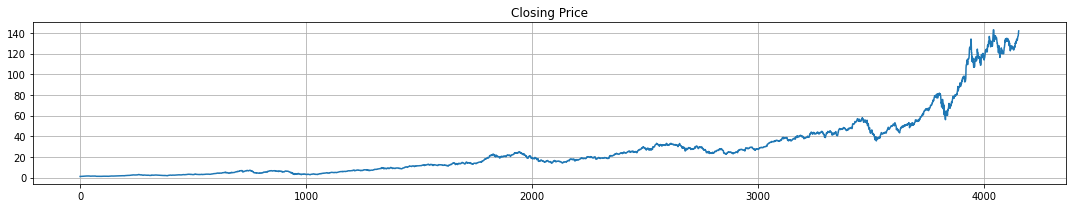

In [ ]:
#@title
# Perform a split
m, n = dataset1.shape
rsplit = 0.8
 
# split into train and test sets
train_size = int(rsplit * m)
test_size = m - train_size
 
# Plot the data closing
fig = plt.figure(figsize=(15,3))
plt.plot(dataset1['Close'].values)
plt.title('Closing Price')
plt.grid()
fig.tight_layout()
plt.savefig('price_{}.pdf'.format(TICKER), format='pdf')
plt.show()

In [ ]:
# create a new datafram with close price only
data = dataset1.filter(['Close_t+26'])
#convert the data dataframe to numpy array
data1= data.values
#get the number of rows to train the model 
training_data_len =math.ceil(len(data1) * .8)

training_data_len


3324

In [ ]:
data1.ndim

2

In [ ]:
 
# Drop rows with future predictions NaN
dataset1 = dataset1[dataset1['Close_t+26'].notnull()] #<--- kills 04-04-2018 cannot be used.
 
# Replace all NaNs in predictors with a sentinel
# With the exception of the Close price, impute by last value
dataset1['Close_t+26'] = dataset1['Close_t+26'].fillna(dataset1['Close_t+26'].iloc[-26 - 1])
dataset1['dClose_t+26'] = dataset1['dClose_t+26'].fillna(dataset1['dClose_t+26'].iloc[-26 - 1])
 
sentinel = -0.123456
dataset1.fillna(value=sentinel, inplace=True)
 
train, test = dataset1.iloc[0:train_size,:], dataset1.iloc[train_size:m,:]
 
# Make data look more stationary
scaler_y = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler_y.fit_transform(data1)

#data1 = np.sqrt(data1)

X_train = train.drop(['Close_t+26','Date'], axis=1)
X_test = test.drop(['Close_t+26','Date'], axis=1)
y_train = train['Close_t+26']
y_test = test['Close_t+26']

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
 
X_train_sc = X_train_sc.astype('float32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [ ]:
dataset1.isnull().sum()

Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
MACD_26_12        0
MACDsign_26_12    0
MACDdiff_26_12    0
BollingerB_30     0
Bollinger%b_30    0
BollingerB_40     0
Bollinger%b_40    0
BollingerB_50     0
Bollinger%b_50    0
SO%k              0
SO%d_5            0
SO%d_9            0
SO%d_14           0
CCI_30            0
CCI_40            0
CCI_50            0
ROPC_30           0
ROPC_40           0
ROPC_50           0
ROVC_30           0
ROVC_40           0
ROVC_50           0
William%R_30      0
William%R_40      0
William%R_50      0
dClose_t+26       0
Close_t+26        0
dtype: int64

In [ ]:
X_test_sc.ndim

2

In [ ]:
y_train.shape

(3324,)

In [ ]:
type(test['Close'])

pandas.core.series.Series

In [ ]:
# Generate LSTM
# Check this:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ (BS)
# https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a
# https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f

def rmse(y_true, y_pred):
	return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1))

def soft_acc(y_true, y_pred):
  return keras.backend.mean(keras.backend.equal(keras.backend.round(y_true), keras.backend.round(y_pred)))
mX, nX = X_train.shape
mY,  = y_train.shape
time_steps = 1
batch_size = 16

# reshape input to be [samples, time steps, features]
X_train_sc = np.reshape(X_train_sc, (mX, time_steps, nX))
X_test_sc = np.reshape(X_test_sc, (X_test_sc.shape[0], time_steps, nX))

# reshape output too to be one feature.
y_train = np.reshape(y_train, (mY))
y_test = np.reshape(y_test, (-1))

# Build LSTM
# Check if model exists
try:
    json_file = open('model_{}.json'.format(TICKER), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights('model_{}.h5'.format(TICKER))

except FileNotFoundError:
    
    model=Sequential()
    model.add(LSTM(return_sequences=True,input_shape=(time_steps, nX),units=64, activation='relu'))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(32, return_sequences=False))

    model.add(Dropout(.2))
    model.add(Dense(34))
        
    model.add(Dense(1)) # no matter what, do not change this.  This is since y is a vector. 
    model.add(Activation('relu'))

    
    
      
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,soft_acc])
    model.summary()

    

    
    history = model.fit(X_train_sc, y_train, epochs=100, batch_size=batch_size, verbose=2)
   
    model_json = model.to_json()
    with open('model_{}.json'.format(TICKER), 'w') as json_file:
        json_file.write(model_json)
    model.save_weights("model_{}.h5".format(TICKER))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1, 64)             24832     
_________________________________________________________________
lstm_13 (LSTM)               (None, 1, 32)             12416     
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 34)                1122      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 35        
_________________________________________________________________
activation_9 (Activation)    (None, 1)                

In [ ]:
y_test_orig = pd.DataFrame(y_test, columns=['Close_t+26'])#, index=test.index)
y_test_orig = scaler_y.inverse_transform(y_test_orig)
y_test_orig = pd.DataFrame(y_test_orig, columns=['Close_t+26'], index=test.index)
#y_test_orig = y_test_orig ** 2

predicted_price = model.predict(X_test_sc, batch_size=batch_size) #** 2
#predicted_price = scaler_y.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price.flatten(), index=test.index)

In [ ]:
predicted_price

,0
3324,41.916328
3325,41.929333
3326,41.669971
3327,42.182449
3328,43.007835
...,...
4124,77.957481
4125,77.883965
4126,77.988281
4127,78.205307


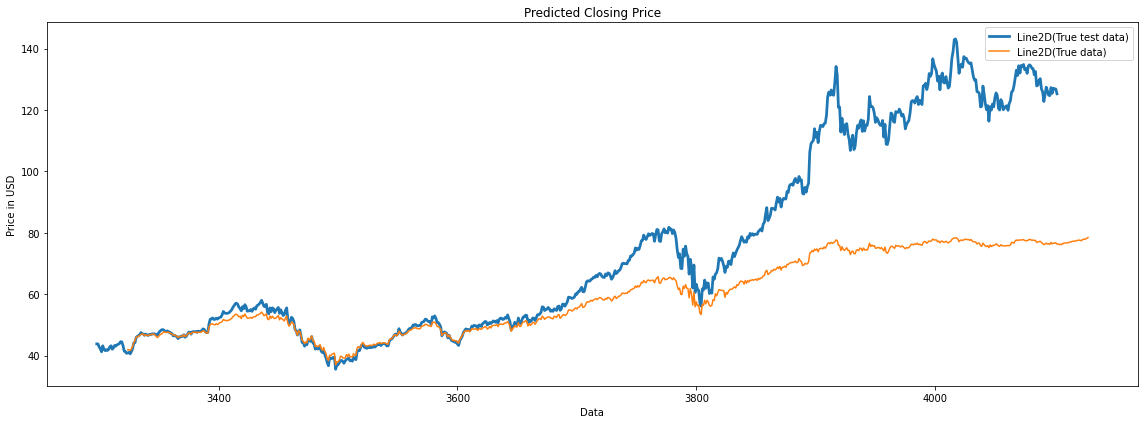

In [ ]:
# Objective: green line to be 100% on the blue one after shift.

fig = plt.figure(figsize=(16,6))
plot_actual, = plt.plot(pd.DataFrame(test['Close'].values, index=y_test.index+-26), linewidth=2.75, label='True test data')
#plot_test, = plt.plot(y_test, label='True data') 
plot_predicted, = plt.plot(predicted_price ,label='Predicted price') 
plt.legend([plot_actual, plot_test, plot_predicted])
plt.ylabel('Price in USD')
plt.xlabel('Data')
plt.title('Predicted Closing Price')
fig.tight_layout()
plt.savefig('prediction_{}.pdf'.format(TICKER), format='pdf')
plt.show()

In [ ]:
# This is the function that generates the requirement
def generate_return(closing_0, closing_30):
    return (closing_30 - closing_0) / closing_0 * 100.

In [ ]:
############################################################################################

# Now compute the return for the next 30 days

y_last_date = predicted_price.iloc[-1,:][0] # this is 5/16/2018 since we are predicting Close t + 30
y_first_date = test['Close'].iloc[-1] # this is 4/4/2018

generated_return = generate_return(y_first_date, y_last_date)

# Conclude
file = open('return_{}.txt'.format(TICKER),'w') 
print('For ticker {0}, the forecasted return is {1:3f}%'.format(TICKER, generated_return))
file.write('For ticker {0}, the forecasted return is {1:3f}%'.format(TICKER, generated_return))

file.close()

For ticker AAPL.NS, the forecasted return is 13.627982%


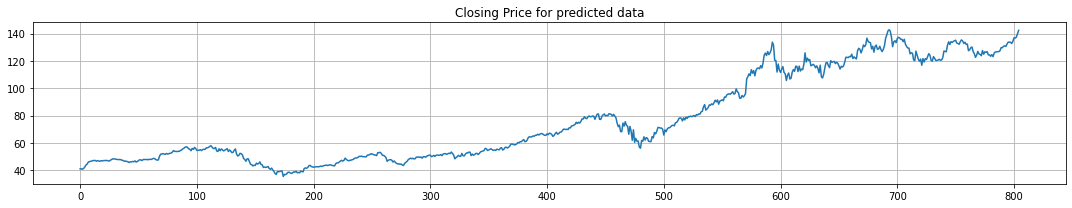

In [ ]:
fig = plt.figure(figsize=(15,3))
plt.plot(predicted_price.values)
plt.title('Closing Price for predicted data')
plt.grid()
fig.tight_layout()
plt.savefig('price_{}.pdf'.format(TICKER), format='pdf')
plt.show()

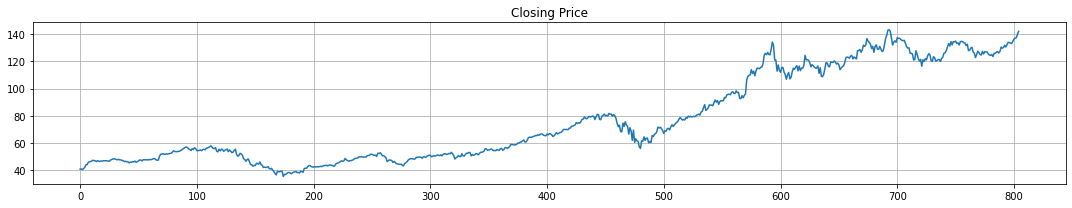

In [ ]:
# Plot the data closing
fig = plt.figure(figsize=(15,3))
plt.plot(y_test.values)
plt.title('Closing Price')
plt.grid()
fig.tight_layout()
plt.savefig('price_{}.pdf'.format(TICKER), format='pdf')
plt.show()

In [ ]:
 # plot metrics
plt.plot(history.history[rmse])
plt.plot(history.history[soft_acc])
plt.show()

KeyError: ignored

KeyError: ignored

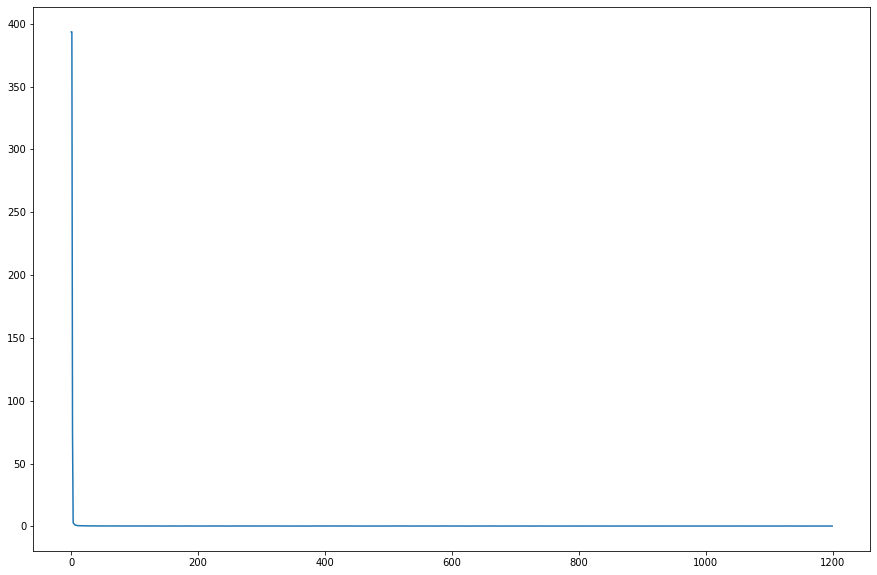

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['metrics'], label='metrics')
plt.legend(loc='best')
plt.show()


In [ ]:
y_test.tail(10)

In [ ]:

predicted_price.tail(10)

In [ ]:
type(predicted_price)

In [ ]:
type(predicted_price)

In [ ]:
y_test= y_test.to_frame()
type(a)

In [ ]:
predicted_price=y_hat.to_numpy()

In [ ]:
real_price = X_test['Close'].to_numpy()

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['rmse'])
plt.plot(history.history['soft_acc'])
plt.show()

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')

In [ ]:
predicted_price = np.reshape(predicted_price,805).ndim

In [ ]:
y_hat.tail(20)

In [ ]:
y_test.tail(20)

In [ ]:
accuracy_score(y_hat_1,y_test)

In [ ]:
clf.score(y_hat_1, y_test)


In [ ]:
 clf.score(x_train,y_train) 

In [ ]:
apple_training_complete = pd.read_csv('AAPL_2005_2021_7_7AAASSDASDAS.csv') 
apple_training_processed = apple_training_complete.iloc[:, 1:2].values


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

apple_training_scaled = scaler.fit_transform(apple_training_processed)

In [ ]:
features_set = []
labels = []
for i in range(60, 1260):
    features_set.append(apple_training_scaled[i-60:i, 0])
    labels.append(apple_training_scaled[i, 0])

In [ ]:
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [ ]:
model.fit(features_set, labels, epochs = 100, batch_size = 32)
apple_testing_complete = pd.read_csv('ASDASDASDASDASD.csv')
apple_testing_processed = apple_testing_complete.iloc[:, 1:2].values

In [ ]:
apple_total = pd.concat((apple_training_complete['Open'], apple_testing_complete['Open']), axis=0)


In [ ]:
test_inputs = apple_total[len(apple_total) - len(apple_testing_complete) - 60:].values
test_inputs

In [ ]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [ ]:
test_features = []
for i in range(60, 80):
    test_features.append(test_inputs[i-60:i, 0])

In [ ]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [ ]:
predictions = model.predict(test_features)






In [ ]:
predictions = scaler.inverse_transform(predictions)
predictions

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(apple_testing_processed, color='blue', label='Actual Apple Stock Price')
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()